In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
HIST_PATH = "historical_data.csv"
SENT_PATH = "fear_greed_index.csv"
OUTPUT_DIR = "/mnt/data/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Utilities

In [3]:
def find_column(df, keywords):
    for col in df.columns:
        c = col.lower()
        for k in keywords:
            if k in c:
                return col
    return None

In [4]:
def directional_flags(row, size_col, start_pos_col):
    side = str(row["side_clean"]).lower()
    start = str(row[start_pos_col]).lower() if start_pos_col in row else ""
    if "buy" in side:
        return True, False
    if "sell" in side:
        return False, True
    try:
        s = float(row[size_col])
        if s > 0:
            return True, False
        if s < 0:
            return False, True
    except:
        pass
    if "long" in start:
        return True, False
    if "short" in start:
        return False, True
    return False, False

In [5]:
def welch_test(a, b):
    a = a.dropna().values
    b = b.dropna().values
    if len(a) < 2 or len(b) < 2:
        return np.nan, np.nan
    ma, mb = a.mean(), b.mean()
    va, vb = a.var(ddof=1), b.var(ddof=1)
    t = (ma - mb) / np.sqrt(va/len(a) + vb/len(b))
    try:
        from scipy import stats
        dfc = (va/len(a) + vb/len(b))**2 / ((va**2)/((len(a)**2)*(len(a)-1)) + (vb**2)/((len(b)**2)*(len(b)-1)))
        p = stats.t.sf(abs(t), dfc) * 2
    except:
        z = abs(t)
        p = 2*(1 - 0.5*(1 + erf(z/np.sqrt(2))))
    return t, p

Loading Datasets

In [6]:
hist = pd.read_csv(HIST_PATH, low_memory=False)
sent = pd.read_csv(SENT_PATH, low_memory=False)

In [7]:
hist.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [8]:
sent.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Column Detetion

In [9]:
print("History Data columns\n",hist.columns)
print("Sentiment Data columns\n",sent.columns)

History Data columns
 Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Sentiment Data columns
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [10]:
time_col = find_column(hist, ["time"])
side_col = find_column(hist, ["side"])
price_col = find_column(hist, ["price"])
pnl_col = find_column(hist, ["closed pnl", "closed_pnl", "pnl"])
size_col = find_column(hist, ["size tokens", "size"])
fee_col = find_column(hist, ["fee"])
start_pos_col = find_column(hist, ["start position"])

Data Cleaning

In [11]:
print("HISTORICAL DATA\n")
print("Null values\n",hist.isnull().sum())
print("Duplicated Values",hist.duplicated().sum())
print("Data Types\n",hist.dtypes)

HISTORICAL DATA

Null values
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicated Values 0
Data Types
 Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object


In [12]:
print("SENTIMENT DATA\n")
print("Null values\n",sent.isnull().sum())
print("Duplicated Values",sent.duplicated().sum())
print("Data Types\n",sent.dtypes)

SENTIMENT DATA

Null values
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicated Values 0
Data Types
 timestamp          int64
value              int64
classification    object
date              object
dtype: object


In [13]:
hist["time_clean"] = pd.to_datetime(hist[time_col], errors="coerce")
hist = hist.dropna(subset=["time_clean"])
hist["date"] = hist["time_clean"].dt.normalize()

num_cols = [size_col, price_col, pnl_col, fee_col]
for c in num_cols:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors="coerce")

hist["side_clean"] = hist[side_col].astype(str).str.lower().str.strip()
hist["is_long"], hist["is_short"] = zip(*hist.apply(lambda r: directional_flags(r, size_col, start_pos_col), axis=1))

hist["pnl"] = hist[pnl_col] if pnl_col in hist.columns else np.nan
hist["abs_size"] = hist[size_col].abs() if size_col in hist.columns else np.nan


Daily Aggregation

In [14]:
daily = hist.groupby("date").agg(
    trade_count=("time_clean","count"),
    total_volume=("abs_size","sum"),
    total_pnl=("pnl","sum"),
    mean_pnl=("pnl","mean"),
    pnl_std=("pnl","std"),
    win_rate=("pnl", lambda x: (x > 0).mean()),
    long_volume=("abs_size", lambda x: x[hist.loc[x.index,"is_long"]].sum()),
    short_volume=("abs_size", lambda x: x[hist.loc[x.index,"is_short"]].sum()),
    total_fees=(fee_col, "sum") if fee_col in hist.columns else ("time_clean", lambda x: np.nan)
).reset_index()

daily["bias"] = (daily["long_volume"] - daily["short_volume"]) / (daily["total_volume"] + 1e-9)

Sentiment Mapping

In [15]:
sent_date_col = find_column(sent, ["date"])
sent_class_col = find_column(sent, ["class", "classification"])
sent_value_col = find_column(sent, ["value"])

sent["date"] = pd.to_datetime(sent[sent_date_col], errors="coerce")
sent = sent.dropna(subset=["date"])
sent["class_clean"] = sent[sent_class_col].astype(str).str.lower().str.strip()

mapping = {
    "extreme fear": 0,
    "fear": 1,
    "neutral": 2,
    "greed": 3,
    "extreme greed": 4
}

sent["sent_num"] = sent["class_clean"].map(mapping).fillna(2)

Merge Datasets

In [16]:
merged = pd.merge(daily, sent[["date","class_clean","sent_num"]], on="date", how="left")
merged["sent_num_filled"] = merged["sent_num"].fillna(method="ffill").fillna(2)

In [17]:
merged.head()

,date,trade_count,total_volume,total_pnl,mean_pnl,pnl_std,win_rate,long_volume,short_volume,total_fees,bias,class_clean,sent_num,sent_num_filled
0,2023-01-05,3,2.513000e-01,0.000000,0.000000,0.000000,0.000000,2.513000e-01,0.000000e+00,0.000000,1.000000,fear,1.0,1.0
1,2023-05-12,9,1.180901e+01,0.000000,0.000000,0.000000,0.000000,1.121190e+01,5.971100e-01,12.501455,0.898872,neutral,2.0,2.0
2,2024-01-01,18,4.178787e+03,-129.531460,-7.196192,85.847769,0.055556,2.089393e+03,2.089393e+03,66.059867,0.000000,greed,3.0,3.0
3,2024-01-02,6,4.498600e+04,0.000000,0.000000,0.000000,0.000000,4.498600e+04,0.000000e+00,0.502044,1.000000,greed,3.0,3.0
4,2024-01-03,137,2.598468e+07,8244.241409,60.176945,111.958609,0.934307,1.299234e+07,1.299234e+07,-0.546854,0.000000,greed,3.0,3.0


In [18]:
print(merged.columns)

Index(['date', 'trade_count', 'total_volume', 'total_pnl', 'mean_pnl',
       'pnl_std', 'win_rate', 'long_volume', 'short_volume', 'total_fees',
       'bias', 'class_clean', 'sent_num', 'sent_num_filled'],
      dtype='object')


Summary Tables

In [19]:
summary = merged.groupby("class_clean").agg(
    days=("date", "count"),

    avg_pnl=("total_pnl", "mean"),
    median_pnl=("total_pnl", "median"),
    std_pnl=("total_pnl", "std"),

    avg_volume=("total_volume", "mean"),
    median_volume=("total_volume", "median"),
    std_volume=("total_volume", "std"),

    avg_trade_count=("trade_count", "mean"),
    median_trade_count=("trade_count", "median"),
    std_trade_count=("trade_count", "std"),

    avg_win_rate=("win_rate", "mean"),
    median_win_rate=("win_rate", "median"),
    std_win_rate=("win_rate", "std"),

    avg_bias=("bias", "mean"),
    median_bias=("bias", "median"),
    std_bias=("bias", "std")
).reset_index()

summary.to_csv(os.path.join("summary_by_sentiment.csv"), index=False)

In [20]:
merged.to_csv(os.path.join("merged_daily.csv"), index=False)

In [21]:
summary_table = pd.DataFrame(summary)
summary_table

,class_clean,days,avg_pnl,median_pnl,std_pnl,avg_volume,median_volume,std_volume,avg_trade_count,median_trade_count,std_trade_count,avg_win_rate,median_win_rate,std_win_rate,avg_bias,median_bias,std_bias
0,extreme fear,6,733.322758,64.569420,2798.334049,9.536770e+05,8485.558519,2.146220e+06,387.666667,23.0,694.736113,0.307500,0.273758,0.366348,-0.094848,-0.176946,0.838083
1,extreme greed,43,26904.504083,541.554710,112472.212014,2.144779e+06,34544.420600,8.247906e+06,130.720930,25.0,344.856514,0.319642,0.291667,0.254195,0.162240,0.001181,0.695309
2,fear,37,48087.177910,1147.595856,132965.887414,1.206927e+06,84372.310800,3.574559e+06,374.837838,67.0,700.071366,0.348071,0.298611,0.289032,-0.041528,-0.004007,0.636633
3,greed,56,10886.295226,423.083319,39493.424342,3.015824e+06,71981.671955,9.465829e+06,201.642857,55.5,344.301899,0.362415,0.340058,0.285226,0.052856,0.000000,0.646422
4,neutral,16,4666.046374,97.704185,10806.052601,3.052417e+06,39967.831050,1.120473e+07,172.250000,61.0,386.781851,0.286719,0.231218,0.270487,0.064057,-0.000052,0.661481


Correlation

In [22]:
corr_columns = [
    "total_pnl",
    "total_volume",
    "trade_count",
    "win_rate",
    "bias",
    "sent_num_filled"
]

corr_matrix = merged[corr_columns].corr()
corr_matrix.to_csv(os.path.join("correlation_matrix.csv"))

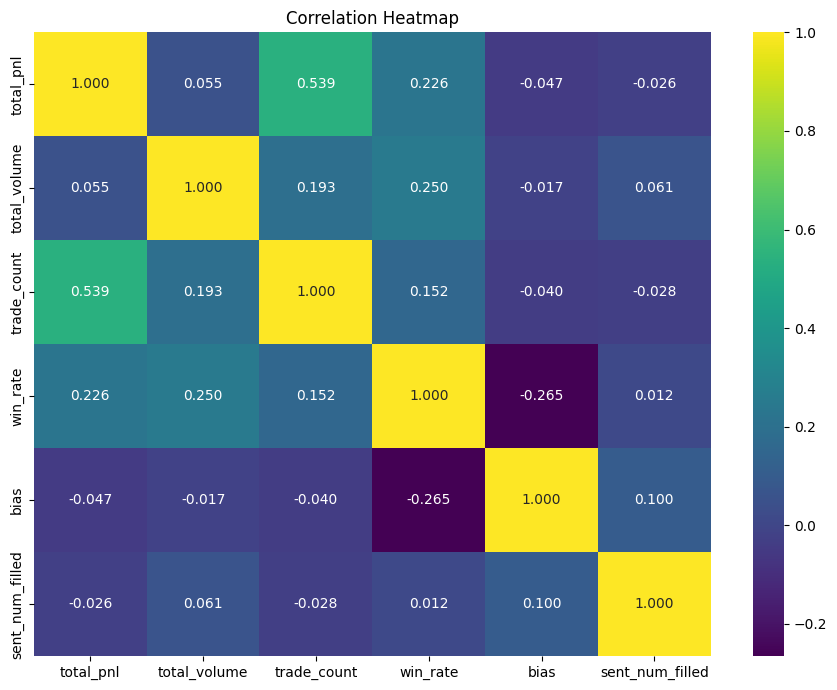

In [23]:
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".3f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join("correlation_heatmap.png"))
plt.show()

Visualization

In [24]:
sentiment_colors = {
    0: "darkred",
    1: "red",
    2: "gray",
    3: "lightgreen",
    4: "green"
}

sentiment_labels = {
    0: "Extreme Fear",
    1: "Fear",
    2: "Neutral",
    3: "Greed",
    4: "Extreme Greed"
}

merged["sent_color"] = merged["sent_num_filled"].map(sentiment_colors)

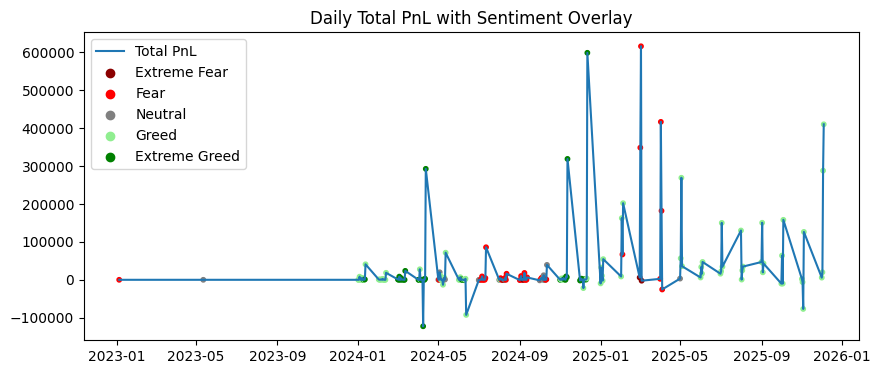

In [25]:
plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["total_pnl"], label="Total PnL")
plt.scatter(merged["date"], merged["total_pnl"], c=merged["sent_color"], s=10)

for v,l in sentiment_labels.items():
    plt.scatter([], [], color=sentiment_colors[v], label=l)

plt.title("Daily Total PnL with Sentiment Overlay")
plt.legend()
plt.savefig("ts_pnl.png")
plt.show()

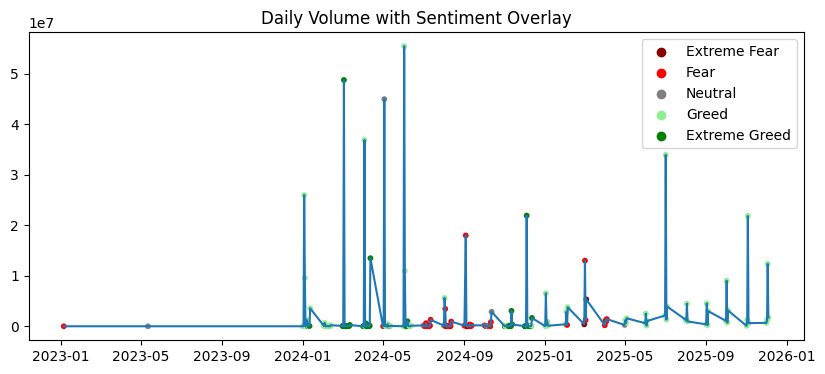

In [26]:
plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["total_volume"])
plt.scatter(merged["date"], merged["total_volume"], c=merged["sent_color"], s=10)

for v,l in sentiment_labels.items():
    plt.scatter([], [], color=sentiment_colors[v], label=l)

plt.title("Daily Volume with Sentiment Overlay")
plt.legend()
plt.savefig("ts_volume.png")
plt.show()


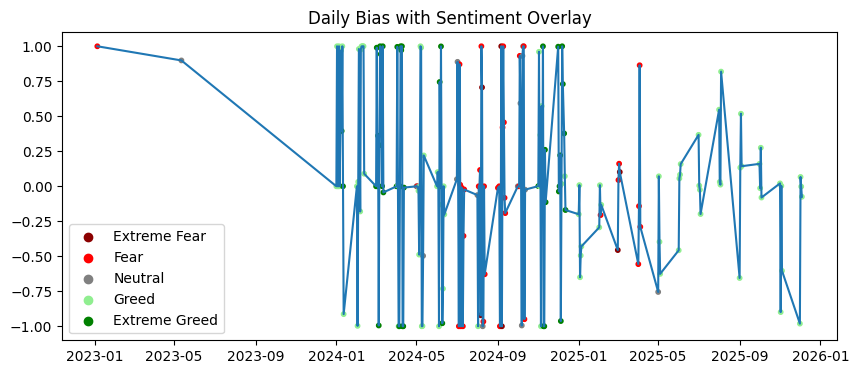

In [27]:
plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["bias"])
plt.scatter(merged["date"], merged["bias"], c=merged["sent_color"], s=10)

for v,l in sentiment_labels.items():
    plt.scatter([], [], color=sentiment_colors[v], label=l)

plt.title("Daily Bias with Sentiment Overlay")
plt.legend()
plt.savefig("ts_bias.png")
plt.show()


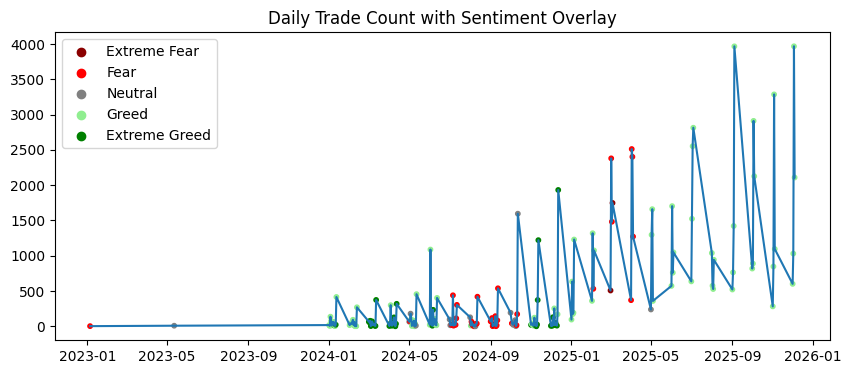

In [28]:
plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["trade_count"])
plt.scatter(merged["date"], merged["trade_count"], c=merged["sent_color"], s=10)

for v,l in sentiment_labels.items():
    plt.scatter([], [], color=sentiment_colors[v], label=l)

plt.title("Daily Trade Count with Sentiment Overlay")
plt.legend()
plt.savefig("ts_tradecount.png")
plt.show()


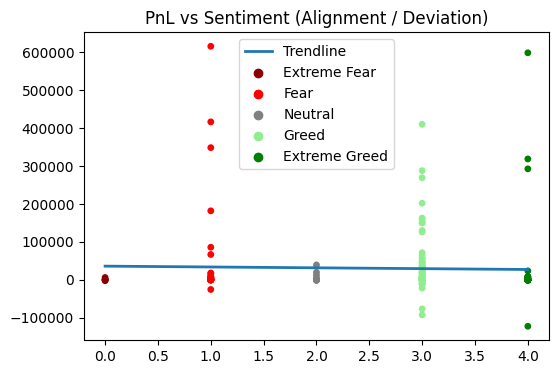

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(merged["sent_num_filled"], merged["total_pnl"], c=merged["sent_color"], s=15)

m, b = np.polyfit(merged["sent_num_filled"], merged["total_pnl"], 1)
x = np.array([merged["sent_num_filled"].min(), merged["sent_num_filled"].max()])
plt.plot(x, m*x + b, linewidth=2, label="Trendline")

for v,l in sentiment_labels.items():
    plt.scatter([], [], color=sentiment_colors[v], label=l)

plt.title("PnL vs Sentiment (Alignment / Deviation)")
plt.legend()
plt.savefig("rel_pnl_scatter.png")
plt.show()

In [30]:
palette_class = {
    "extreme fear": "darkred",
    "fear": "red",
    "neutral": "gray",
    "greed": "lightgreen",
    "extreme greed": "green"
}


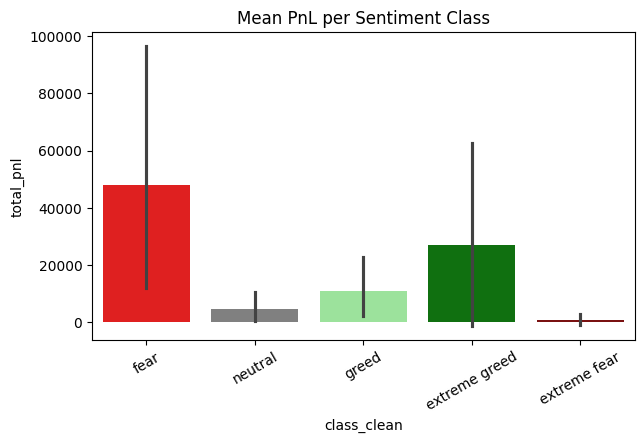

In [31]:


plt.figure(figsize=(7,4))
sns.barplot(data=merged, x="class_clean", y="total_pnl", palette=palette_class)
plt.title("Mean PnL per Sentiment Class")
plt.xticks(rotation=30)
plt.savefig("bar_pnl.png")
plt.show()


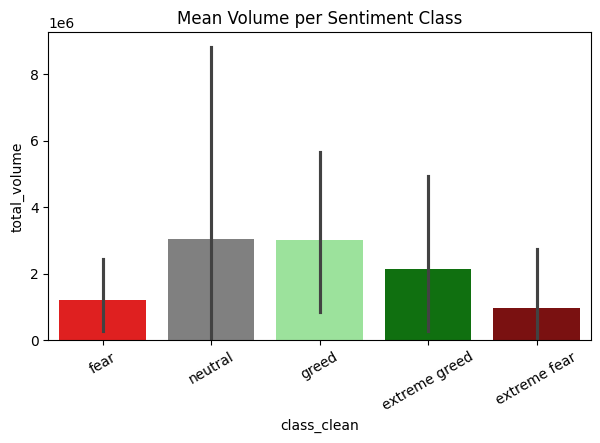

In [32]:
plt.figure(figsize=(7,4))
sns.barplot(data=merged, x="class_clean", y="total_volume", palette=palette_class)
plt.title("Mean Volume per Sentiment Class")
plt.xticks(rotation=30)
plt.savefig("bar_volume.png")
plt.show()

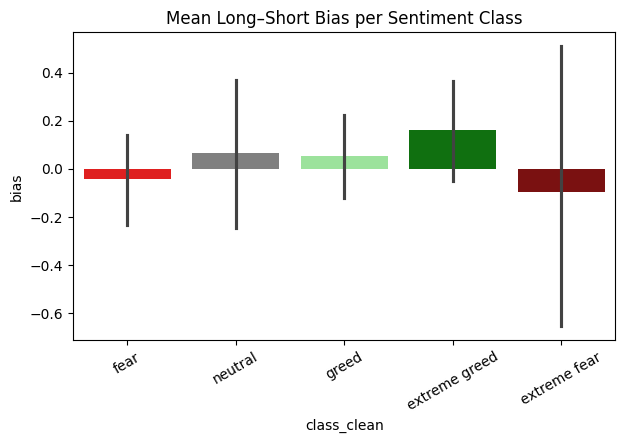

In [33]:
plt.figure(figsize=(7,4))
sns.barplot(data=merged, x="class_clean", y="bias", palette=palette_class)
plt.title("Mean Long–Short Bias per Sentiment Class")
plt.xticks(rotation=30)
plt.savefig("bar_bias.png")
plt.show()
